In [972]:
import quandl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from config import api_key
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy
import datetime
%matplotlib inline

In [973]:
quandl.ApiConfig.api_key = api_key
#Variance Risk Premium: https://sites.google.com/site/haozhouspersonalhomepage
#EOM Nominal S&P, Nominal Dividends / Nominal Risk Free Rate: http://www.hec.unil.ch/agoyal/
#Consumer Sentiment: http://www.sca.isr.umich.edu/

In [974]:
ticker = 'SPY'
transform = 'normalize'
start_date = '1989-01-01'
end_date = '2018-12-31'
period = 'monthly'

In [975]:
#Access data from Quandl
ticker_data = quandl.get('EOD/' + ticker, start_date=start_date, end_date=end_date, collapse=period)
risk_free_rate = quandl.get('FRED/DTB3', start_date=start_date, end_date=end_date, collapse=period)
fed_funds_rate = quandl.get('FRED/FEDFUNDS', start_date=start_date, end_date=end_date, collapse=period)

#Confirm results are same size:
if ticker_data.shape[0] == risk_free_rate.shape[0] == fed_funds_rate.shape[0]:
    
    print(f"All dataframes are {ticker_data.shape[0]} rows")

else:
    print('Dataframes are not the same size:',  
          f'ticker_data is {ticker_data.shape[0]}, ',
          f'risk_free_rate is {risk_free_rate.shape[0]}, ',
          f'fed_funds_rate is {fed_funds_rate.shape[0]}.');

Dataframes are not the same size: ticker_data is 312,  risk_free_rate is 360,  fed_funds_rate is 360.


In [976]:
#Make Function to Create Return Column for Risk Free Rate & Fed Funds Rate
def make_return_column(data):
    
    list_return = []

    for i in range(len(data)):
        x = (data.iloc[i]['Value']/12)/100
        list_return.append(x)
        
    temp_df = pd.DataFrame(list_return)
    
    data = pd.concat([data.reset_index(), temp_df.reset_index(drop=True)], axis=1)
    data = data.rename(columns={0: 'return'})
    
    return data

risk_free_df = make_return_column(risk_free_rate)

In [977]:
fed_funds_df = pd.DataFrame(fed_funds_rate.reset_index())

In [978]:
fed_funds_df18 = fed_funds_df[fed_funds_df['Date'] >= '2018-01-01']
fed_funds_df = fed_funds_df[fed_funds_df['Date'] < '2018-01-01']

In [979]:
fed_funds_df18 = fed_funds_df18['Value']
fed_funds_df = fed_funds_df['Value']

In [980]:
"""
BUILD DATASET

Monthly >>>
Index: S&P 500 Index Data
D12: Dividends are 12-month moving sums of dividends paid on the S&P 500 index (Goyal, Welch) 
     -- Confirmed with Y Charts
Rfree: Nominal Risk Free Rate
"""
goyal = pd.read_excel('PredictorData2017.xlsx')
df = pd.DataFrame(goyal)

#New DF with cleaned up Columns
df_cols = ['yyyymm', 'Index', 'D12', 'Rfree']
df = df[df_cols]

#Convert yyyymm to Datetime then to Period
yyyymm = pd.to_datetime(df['yyyymm'], format='%Y%m').dt.strftime('%Y-%m')
df['yyyymm'] = pd.to_datetime(yyyymm, format='%Y-%m')

#Drop rows prior to 1990-01
df = df[df['yyyymm'] >= '1990-01'];

In [981]:
"""
VRP: Variance Risk Premium = IV - RV
IV: Implied Variance = VIX-Squared/12
RV: Realized Variance = Sum of Squared 5-minute log returns of the S&P 500 Index
"""
vrp = pd.read_fwf('VRPtable.txt')
df_vrp = pd.DataFrame(vrp)

#Drop 2018 Rows & create new VRP 2018 DF
df_vrp2018 = df_vrp[df_vrp['Year'] >= 2018]
df_vrp = df_vrp[df_vrp['Year'] < 2018]


#Drop Unnecessary Columns
df_vrp2018 = df_vrp2018[['VRP']]
df_vrp = df_vrp[['VRP']];

In [982]:
#Concat Index DF with VRP DF
df = pd.concat([df.reset_index(drop=True), df_vrp.reset_index(drop=True)], axis=1)

In [983]:
#Rename yyyymm Column to EOM
df = df.rename(columns={'yyyymm': 'EOM'})

In [984]:
#New DF from Index / Div / Rfree Data -> Need to Add 1989 Data.
df_1989 = pd.DataFrame(goyal)
df_1989_cols = ['yyyymm', 'Index', 'D12', 'Rfree']

df_1989 = df_1989[df_1989_cols]
yyyymm_1989 = pd.to_datetime(df_1989['yyyymm'], format='%Y%m').dt.strftime('%Y-%m')
df_1989['yyyymm']  = pd.to_datetime(yyyymm_1989, format='%Y-%m')

df_1989 = df_1989[(df_1989['yyyymm'] >= '1989-01') & (df_1989['yyyymm'] < '1990-01')]

df_1989 = df_1989.rename(columns={'yyyymm': 'EOM'})

df = pd.concat([df_1989, df], axis=0, ignore_index=True, sort=False)

In [985]:
#Concat Fed Funds Rate
df = pd.concat([df.reset_index(drop=True), fed_funds_df.reset_index(drop=True)], axis=1)
df = df.rename(columns={'Value': 'fed_funds'})

In [986]:
#Import Consumer Sentiment Data
sentiment_file = 'tbmics.csv'
sentiment = pd.read_csv(sentiment_file)

sentiment18 = sentiment[(sentiment['YYYY'] >= 2018) & (sentiment['YYYY'] < 2019)]
sentiment = sentiment[(sentiment['YYYY'] >= 1989) & (sentiment['YYYY'] < 2018)]


In [987]:
sentiment18 = sentiment18['ICS_ALL']
sentiment = sentiment['ICS_ALL']

In [988]:
df = pd.concat([df.reset_index(drop=True), sentiment.reset_index(drop=True)], axis=1)

In [989]:
"""
2018 Data
"""

#2018 S&P 500 Dividends
dividends18 = 'Dividend_History.csv'
div_data18 = pd.read_csv(dividends18)
div18 = pd.DataFrame(div_data18)

div18 = div18[['Value']]
div18 = div18.rename(columns={'Value': 'D12'})

#2018 S&P Index Data from Yahoo
f2018 = '^GSPC.csv'
data = pd.read_csv(f2018)
sp18 = pd.DataFrame(data)
sp18 = sp18[['Date', 'Close']]

sp18 = pd.concat([sp18.reset_index(drop=True), df_vrp2018.reset_index(drop=True)], axis=1);

In [990]:
#Concat 2018 DF with Risk Free Rate Data
rfdf18 = risk_free_df['return'].tail(12)
sp18 = pd.concat([sp18.reset_index(drop=True), rfdf18.reset_index(drop=True)], axis=1)
sp18 = sp18.rename(columns={'return': 'Rfree'})

In [991]:
#Concat 2018 federal funds rate return
sp18 = pd.concat([sp18.reset_index(drop=True), fed_funds_df18.reset_index(drop=True)], axis=1)
sp18 = sp18.rename(columns={'Value': 'fed_funds'})

In [992]:
#Cocnat 2018 Dividends and clean up columns
sp18 = pd.concat([sp18.reset_index(drop=True), div18.reset_index(drop=True)], axis=1)
sp18 = sp18.rename(columns={'Close': 'Index', 'Date': 'EOM'})
sp18['EOM'] = pd.to_datetime(sp18['EOM'])

In [993]:
#Concat 2018 Sentiment
sp18 = pd.concat([sp18.reset_index(drop=True), sentiment18.reset_index(drop=True)], axis=1)

In [994]:
#Reorder Columns
cols = ['EOM', 'Index', 'D12', 'Rfree', 'fed_funds', 'VRP', 'ICS_ALL']
sp18 = sp18[cols]
df = df[cols]

In [995]:
#Create Dataframe with all Data from 1989 to 2018
df_all = pd.concat([df.reset_index(drop=True), sp18.reset_index(drop=True)], axis=0)

In [996]:
def build_df(df):
    
    #Number of Periods in Variance Risk Premium
    vrp_rolling_periods = 3

    #Create Column with PD Ratio
    df['pd'] = (df['Index'] / df['D12'])

    #Create Column with Fed Funds Rate Delta (12 Month)
    df['ff12_D'] = df['fed_funds'] - df['fed_funds'].shift(12)

    #Create Column with Rolling Variance Risk Premium Rolling
    df['vrp3'] = df['VRP'].rolling(vrp_rolling_periods).mean()

    #Create Column with Sentiment Delta
    df['sent12_D'] = (df['ICS_ALL'] - df['ICS_ALL'].shift(12))
    
    #Create Column with Excess Return on Index Relative to the RFR in percent
    df['ersf'] = (((df['Index'] + df['D12']/12 - df['Index'].shift(1)) / df['Index'].shift(1)) - df['Rfree']) * 100

    #Create Column with Excess Return on Index Relative to the RFR in percent
    df['ersf_t1'] = (((df['Index'].shift(-1) + df['D12'].shift(-1)/12 - df['Index']) / df['Index']) - df['Rfree'].shift(-1)) * 100

    #Create Column with 1-month Delta in ersf
    df['ersf_D'] = df['ersf'] - df['ersf'].shift(1)

    #Create column with Sentiment X ersf Delta
    df['sent_x_ersf_D'] = df['sent12_D'] * df['ersf_D']
    
    return df

df_all = build_df(df_all)

In [997]:
# Create Filter for 2003 to 2018
filt_2003 = (df_all['EOM'] >= '2003-01-01')
df0318 = df_all[filt_2003]

#Cut off 2013
df0418 = df0318[12:]

In [998]:
google_trends_file = 'GoogleTrends_2004-2018.csv'

google_data = pd.read_csv(google_trends_file)
google = pd.DataFrame(google_data)
google = google[1:]

google = google.rename(columns={'Category: All categories': 'Google'})
google['Google'] = google['Google'].astype('float64')
google['Google_D'] = google['Google'] - google['Google'].shift(1)
google.fillna(google.mean(), inplace=True)

df0418 = pd.concat([df0418.reset_index(drop=True), google.reset_index(drop=True)], axis=1)

df0418.head()
df0418.tail()

,EOM,Index,D12,Rfree,fed_funds,VRP,ICS_ALL,pd,ff12_D,vrp3,sent12_D,ersf,ersf_t1,ersf_D,sent_x_ersf_D,Google,Google_D
0,2004-01-01,1131.13,17.598000,0.000733,1.00,14.0860,103.8,64.276054,-0.24,16.151067,21.4,1.786198,1.274621,-3.352254,-71.738239,28.0,0.273743
1,2004-02-01,1144.94,17.811000,0.000775,1.01,9.8728,94.4,64.282747,-0.25,14.917533,14.5,1.274621,-1.583041,-0.511577,-7.417861,28.0,0.000000
2,2004-03-01,1126.21,18.024000,0.000783,1.00,9.4462,95.8,62.483910,-0.25,11.135000,18.2,-1.583041,-1.622623,-2.857662,-52.009454,26.0,-2.000000
3,2004-04-01,1107.30,18.216667,0.000783,1.00,13.4427,94.2,60.784995,-0.26,10.920567,8.2,-1.622623,1.261890,-0.039582,-0.324572,25.0,-1.000000
4,2004-05-01,1120.68,18.409333,0.000850,1.00,5.2403,90.2,60.875643,-0.26,9.376400,-1.9,1.261890,1.831398,2.884513,-5.480574,23.0,-2.000000


,EOM,Index,D12,Rfree,fed_funds,VRP,ICS_ALL,pd,ff12_D,vrp3,sent12_D,ersf,ersf_t1,ersf_D,sent_x_ersf_D,Google,Google_D
175,2018-08-01,2901.520020,52.31,0.001725,1.91,8.5030,96.2,55.467789,0.75,9.972800,-0.6,3.008605,0.399293,-0.589272,0.353563,33.0,1.0
176,2018-09-01,2913.979980,51.89,0.001792,1.95,7.9528,100.1,56.156870,0.80,8.198900,5.0,0.399293,-6.984062,-2.609312,-13.046560,31.0,-2.0
177,2018-10-01,2711.739990,51.44,0.001908,2.19,-2.2509,98.6,52.716563,1.04,4.734967,-2.1,-6.984062,1.749912,-7.383355,15.505046,62.0,31.0
178,2018-11-01,2760.169922,51.19,0.001933,2.20,2.7329,97.5,53.920100,1.04,2.811600,-1.0,1.749912,-9.223502,8.733974,-8.733974,48.0,-14.0
179,2018-12-01,2506.850098,51.07,0.002000,2.27,-4.0034,98.3,49.086550,0.97,-1.173800,2.4,-9.223502,NaN,-10.973414,-26.336194,77.0,29.0


In [999]:
df0418['Google_D2'] = df0418['Google_D'] - df0418['Google_D'].shift(1)

In [1000]:
df0418['Google_D2'] = df0418['Google_D2'].fillna(df0418['Google_D2'].mean())
df0418.head()

,EOM,Index,D12,Rfree,fed_funds,VRP,ICS_ALL,pd,ff12_D,vrp3,sent12_D,ersf,ersf_t1,ersf_D,sent_x_ersf_D,Google,Google_D,Google_D2
0,2004-01-01,1131.13,17.598000,0.000733,1.00,14.0860,103.8,64.276054,-0.24,16.151067,21.4,1.786198,1.274621,-3.352254,-71.738239,28.0,0.273743,0.160482
1,2004-02-01,1144.94,17.811000,0.000775,1.01,9.8728,94.4,64.282747,-0.25,14.917533,14.5,1.274621,-1.583041,-0.511577,-7.417861,28.0,0.000000,-0.273743
2,2004-03-01,1126.21,18.024000,0.000783,1.00,9.4462,95.8,62.483910,-0.25,11.135000,18.2,-1.583041,-1.622623,-2.857662,-52.009454,26.0,-2.000000,-2.000000
3,2004-04-01,1107.30,18.216667,0.000783,1.00,13.4427,94.2,60.784995,-0.26,10.920567,8.2,-1.622623,1.261890,-0.039582,-0.324572,25.0,-1.000000,1.000000
4,2004-05-01,1120.68,18.409333,0.000850,1.00,5.2403,90.2,60.875643,-0.26,9.376400,-1.9,1.261890,1.831398,2.884513,-5.480574,23.0,-2.000000,-1.000000


In [1001]:
df0418.tail()
df0418.corr()

,EOM,Index,D12,Rfree,fed_funds,VRP,ICS_ALL,pd,ff12_D,vrp3,sent12_D,ersf,ersf_t1,ersf_D,sent_x_ersf_D,Google,Google_D,Google_D2
175,2018-08-01,2901.520020,52.31,0.001725,1.91,8.5030,96.2,55.467789,0.75,9.972800,-0.6,3.008605,0.399293,-0.589272,0.353563,33.0,1.0,1.0
176,2018-09-01,2913.979980,51.89,0.001792,1.95,7.9528,100.1,56.156870,0.80,8.198900,5.0,0.399293,-6.984062,-2.609312,-13.046560,31.0,-2.0,-3.0
177,2018-10-01,2711.739990,51.44,0.001908,2.19,-2.2509,98.6,52.716563,1.04,4.734967,-2.1,-6.984062,1.749912,-7.383355,15.505046,62.0,31.0,33.0
178,2018-11-01,2760.169922,51.19,0.001933,2.20,2.7329,97.5,53.920100,1.04,2.811600,-1.0,1.749912,-9.223502,8.733974,-8.733974,48.0,-14.0,-45.0
179,2018-12-01,2506.850098,51.07,0.002000,2.27,-4.0034,98.3,49.086550,0.97,-1.173800,2.4,-9.223502,NaN,-10.973414,-26.336194,77.0,29.0,43.0


,Index,D12,Rfree,fed_funds,VRP,ICS_ALL,pd,ff12_D,vrp3,sent12_D,ersf,ersf_t1,ersf_D,sent_x_ersf_D,Google,Google_D,Google_D2
Index,1.000000,0.947547,-0.090170,-0.112394,-0.398257,0.638970,0.096842,0.291096,-0.482939,0.202723,0.071787,-0.031725,-0.020159,0.042375,0.306740,0.065387,0.029199
D12,0.947547,1.000000,-0.243771,-0.257599,-0.257608,0.470198,-0.219543,0.067565,-0.331476,0.125827,-0.002003,-0.004126,-0.015260,0.017869,0.407986,0.055017,0.017257
Rfree,-0.090170,-0.243771,1.000000,0.990510,-0.284534,0.290055,0.476628,0.434211,-0.377155,-0.238049,-0.080117,-0.097563,-0.026363,0.049526,-0.023330,0.035715,0.015182
fed_funds,-0.112394,-0.257599,0.990510,1.000000,-0.274919,0.239967,0.449008,0.363835,-0.360590,-0.278669,-0.093930,-0.112524,-0.022999,0.047269,-0.027912,0.038498,0.017145
VRP,-0.398257,-0.257608,-0.284534,-0.274919,1.000000,-0.504468,-0.455711,-0.388487,0.776145,-0.062451,-0.187874,0.212656,-0.087453,0.022205,-0.115295,-0.133779,-0.135043
ICS_ALL,0.638970,0.470198,0.290055,0.239967,-0.504468,1.000000,0.553759,0.646436,-0.620910,0.468960,0.069708,0.017491,-0.075732,0.011769,0.111409,0.050654,0.040577
pd,0.096842,-0.219543,0.476628,0.449008,-0.455711,0.553759,1.000000,0.697832,-0.496601,0.229713,0.194929,-0.081305,-0.024732,0.069129,-0.292045,0.028571,0.032366
ff12_D,0.291096,0.067565,0.434211,0.363835,-0.388487,0.646436,0.697832,1.000000,-0.438307,0.345149,0.185072,0.170794,-0.021454,0.032351,-0.176936,0.039064,0.023962
vrp3,-0.482939,-0.331476,-0.377155,-0.360590,0.776145,-0.620910,-0.496601,-0.438307,1.000000,-0.009688,0.098661,0.292760,0.099408,-0.123072,-0.094952,-0.063974,-0.050928
sent12_D,0.202723,0.125827,-0.238049,-0.278669,-0.062451,0.468960,0.229713,0.345149,-0.009688,1.000000,0.251093,0.186999,-0.051547,-0.064882,-0.174216,-0.003050,0.024678


In [1002]:
export_csv = df_all.to_csv (r'/Users/maks_p/Flatiron/PROJECT/momentum_sentiment_FINAL/1989_2018_Data.csv', index = None)

In [1003]:
export_csv = df0418.to_csv (r'/Users/maks_p/Flatiron/PROJECT/momentum_sentiment_FINAL/2004_to_2018_withGoogle.csv', index = None)

## Playground - Experimenting with Impact of Additional Variables

In [1004]:
#Better Way to Get S&P 500 Data:
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf

start_sp = datetime.datetime(1989, 1, 1)
end_sp = datetime.datetime(2019, 3, 31)

end_of_last_year = datetime.datetime(2017, 12, 29)

yf.pdr_override()
sp500 = pdr.get_data_yahoo('^GSPC', 
                           start_sp,
                             end_sp)
    
sp500.head()

[*********************100%***********************]  1 of 1 downloaded


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1989-01-03,277.72,277.72,273.81,275.31,275.31,128500000
1989-01-04,275.31,279.75,275.31,279.43,279.43,149700000
1989-01-05,279.43,281.51,279.43,280.01,280.01,174040000
1989-01-06,280.01,282.06,280.01,280.67,280.67,161330000
1989-01-09,280.67,281.89,280.32,280.98,280.98,163180000


In [1005]:
spx = sp500

In [1006]:
spx = spx.reset_index().set_index('Date', drop=False)
spx.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7620 entries, 1989-01-03 to 2019-03-29
Data columns (total 7 columns):
Date         7620 non-null datetime64[ns]
Open         7620 non-null float64
High         7620 non-null float64
Low          7620 non-null float64
Close        7620 non-null float64
Adj Close    7620 non-null float64
Volume       7620 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 476.2 KB


In [1007]:
#Create Volume Weighted Moving Average Column with a Rolling Period of 20 Days
rp = 20

spx['vwma'] = (spx['Close'] * spx['Volume']).rolling(rp).sum() / spx['Volume'].rolling(rp).sum()

In [1008]:
#Create [filt] filter based on start_date and end_date to explore different timeframes
start_date = '2015-01-01'
end_date = '2019-03-31'

filt = (spx['Date'] >= start_date) & (spx['Date'] <= end_date)

sp500_filtered = spx[filt]

In [1009]:
#Create 2004 - 2018 DataFrame to match other DataFrames
sp500_04_18 = spx[(spx['Date'] >= '2004-01-01') & (spx['Date'] < '2019-01-01')]

In [1010]:
#Collapse 2004 - 2018 DataFrame on Month
sp500_04_18_monthly = sp500_04_18.resample('M', on='Date').agg({'Close': 'last', 'Volume': 'sum'})

In [1011]:
sp500_04_18_monthly.tail()

,Close,Volume
Date,,
2018-08-31,2901.52,69238220000
2018-09-30,2913.98,62492080000
2018-10-31,2711.74,91327930000
2018-11-30,2760.17,80080110000
2018-12-31,2506.85,83519570000


In [1012]:
#Exploring Moving Addresses - 20 Day Moving Average of Daily S&P Closing Price
rm = 20

def find_MA_mean(df_close, rm):
    
    return df_close.rolling(rm).mean()

def find_MA_std(df_close, rm):
    
    return df_close.rolling(rm).std()

sp500_mean100day = find_MA_mean(sp500_filt['Close'], rm)
sp500_std100day = find_MA_std(sp500_filt['Close'], rm)

In [1013]:
#Exploring Moving Addresses - 100 Day Moving Average of Daily S&P Closing Price
rm = 100

def find_MA_mean(df_close, rm):
    
    return df_close.rolling(rm).mean()

def find_MA_std(df_close, rm):
    
    return df_close.rolling(rm).std()

sp500_mean100day = find_MA_mean(sp500_filt['Close'], rm)
sp500_std100day = find_MA_std(sp500_filt['Close'], rm)

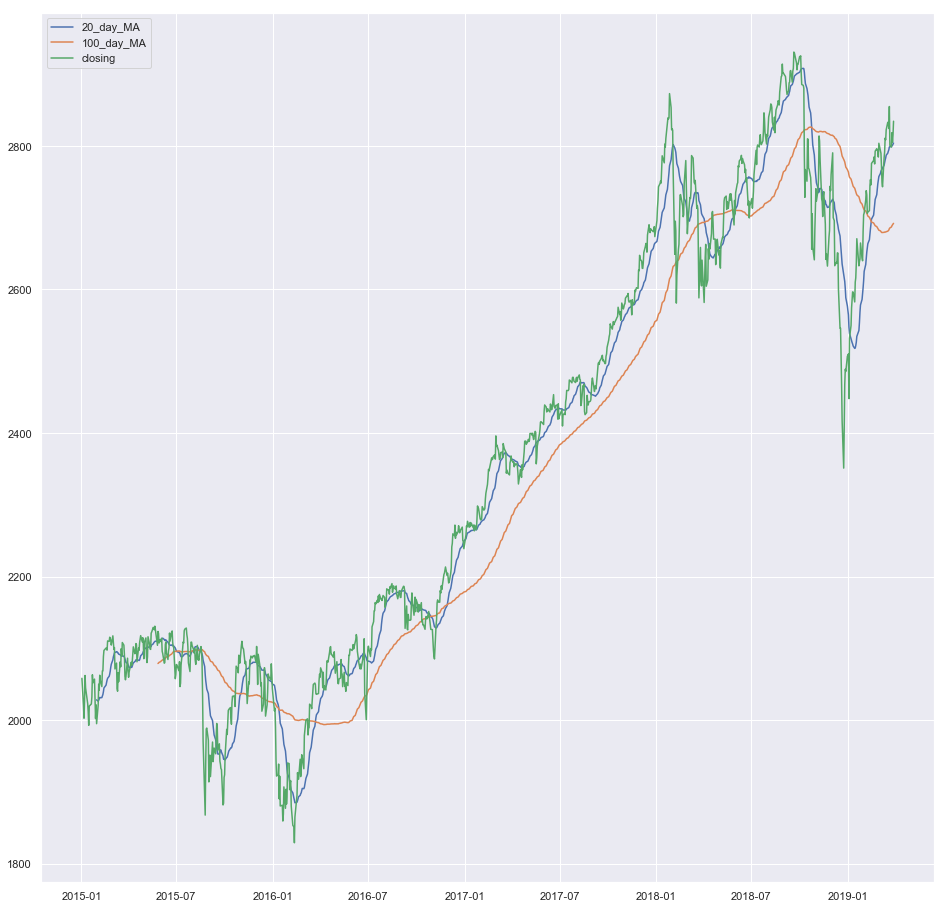

In [1014]:
sns.set()
x = sp500_filt['Date']

plt.figure(figsize=(16,16))

plt.plot(x, sp500_mean20day)
plt.plot(x, sp500_mean100day)
plt.plot(x, sp500_filt['Close'])

plt.legend(['20_day_MA', '100_day_MA', 'closing'], loc='upper left')


plt.show();

In [1015]:
sp500_m = spx.resample('M', on='Date').agg({'Close': 'last', 'Volume': 'sum', 'vwma': 'last'})

In [1016]:
sp500_m.head()

,Close,Volume,vwma
Date,,,
1989-01-31,297.47,3532220000,286.496831
1989-02-28,288.86,3216280000,294.511309
1989-03-31,294.87,3504530000,293.278328
1989-04-30,309.64,3237250000,302.571510
1989-05-31,320.52,3747320000,314.824440


In [1017]:
sp500_m['vwma_delta'] = (sp500_m['vwma'] - sp500_m['vwma'].shift(1)) / sp500_m['vwma'].shift(1)

In [1018]:
sp500_m['volume_delta2'] = (sp500_m['vwma_delta'] - sp500_m['vwma_delta'].shift(1))

In [1019]:
sp500_m = sp500_m.reset_index()
sp500_m.head()
sp500_m.tail()

,Date,Close,Volume,vwma,vwma_delta,volume_delta2
0,1989-01-31,297.47,3532220000,286.496831,NaN,NaN
1,1989-02-28,288.86,3216280000,294.511309,0.027974,NaN
2,1989-03-31,294.87,3504530000,293.278328,-0.004187,-0.032161
3,1989-04-30,309.64,3237250000,302.571510,0.031687,0.035874
4,1989-05-31,320.52,3747320000,314.824440,0.040496,0.008809


,Date,Close,Volume,vwma,vwma_delta,volume_delta2
358,2018-11-30,2760.17,80080110000,2725.576009,-0.010620,0.040456
359,2018-12-31,2506.85,83519570000,2575.203278,-0.055171,-0.044551
360,2019-01-31,2704.10,80391630000,2612.529856,0.014495,0.069666
361,2019-02-28,2784.49,70183430000,2751.844390,0.053326,0.038831
362,2019-03-31,2834.40,78596280000,2804.282655,0.019056,-0.034270


In [1020]:
sp500_m = sp500_m[(sp500_m['Date'] > '2004-01-01') & (sp500_m['Date'] < '2018-01-01')]

In [1021]:
export_csv = sp500_m.to_csv (r'/Users/maks_p/Flatiron/PROJECT/momentum_sentiment_FINAL/04_18_withVWMA.csv', index = None)